# Assignment 0

In [4]:
from matminer.datasets.dataset_retrieval import load_dataset, get_all_dataset_info
from matminer.datasets import get_available_datasets

In [5]:
print(get_all_dataset_info('matbench_perovskites'))

Dataset: matbench_perovskites
Description: Matbench v0.1 test dataset for predicting formation energy from crystal structure. Adapted from an original dataset generated by Castelli et al. For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	e_form: Target variable. Heat of formation of the entire 5-atom perovskite cell, in eV as calculated by RPBE GGA-DFT. Note the reference state for oxygen was computed from oxygen's chemical potential in water vapor, not as oxygen molecules, to reflect the application which these perovskites were studied for.
	structure: Pymatgen Structure of the material.
Num Entries: 18928
Reference: Ivano E. Castelli, David D. Landis, Kristian S. Thygesen, Søren Dahl, Ib Chorkendorff, Thomas F. Jaramillo and Karsten W. Jacobsen (2012) New cubic perovskites for one- and two-photon water splitting using the computational materials repo

In [6]:
import pandas as pd
df_full = load_dataset('matbench_perovskites')
df_full.describe()  # type: ignore

e_form
count  18928.000000
mean       1.470932
std        0.742502
min       -0.640000
25%        0.960000
50%        1.360000
75%        1.840000
max        5.160000

In [7]:
from matminer.datasets.dataset_retrieval import load_dataset
import pandas as pd

# Load dataset
df = load_dataset('matbench_perovskites')
df['matbench_perovskites'] = [f"mat{i}" for i in range(len(df))]

#USE E_FORM AS TARGET
df = df.rename(columns={'e_form': 'TARGET'})
df = df[['matbench_perovskites', 'structure', 'TARGET']]
df['composition'] = df['structure'].apply(lambda x: x.composition)

# Build structure dictionary with string keys
mat_struct_dict = {
    row['matbench_perovskites']: row['structure'].as_dict()
    for _, row in df.iterrows()
}


### everything runs fine until here, then I get errors when I try to initialize the MatFold class

In [8]:
from MatFold import MatFold
mf = MatFold(df, mat_struct_dict, write_data_checksums=False)

In [9]:
print(df.head())
print(df.columns)


  matbench_perovskites                                          structure  \
0                 mat0  [[0. 0. 0.] Rh, [1.97726555 1.97726555 1.97726...   
1                 mat1  [[2.54041798 0.         0.        ] Hf, [1.020...   
2                 mat2  [[0.60790913 0.         0.        ] Re, [2.186...   
3                 mat3  [[2.83091357 0.         0.        ] W, [2.6573...   
4                 mat4  [[0.00518937 0.         0.        ] Bi, [2.172...   

   TARGET     composition  
0    2.16     (Rh, Te, N)  
1    1.52     (Hf, Te, O)  
2    1.48  (Re, As, F, O)  
3    1.24   (W, Re, S, O)  
4    0.62  (Bi, Hf, F, O)  
Index(['matbench_perovskites', 'structure', 'TARGET', 'composition'], dtype='object')


In [10]:
split_keys = [
    "composition",
    "chemsys",
    "sgnum",
    "pointgroup",
    "crystalsys",
    "elements",
    "periodictablerows",
    "periodictablegroups"
]

print("\n=== SPLIT STATISTICS ===\n")

for key in split_keys:
    print(f"----- {key} -----")
    try:
        stats = mf.split_statistics(key)
        print(stats)
    except Exception as e:
        print(f"Could not compute statistics for '{key}': {e}")
    print("\n")



=== SPLIT STATISTICS ===

----- composition -----
{'CdSiNOF': 0.00010566356720202873, 'SrOsN2O': 0.00010566356720202873, 'AgIrNO2': 0.00010566356720202873, 'GaRuO2F': 0.00010566356720202873, 'NaMoNO2': 0.00010566356720202873, 'BeFeSO2': 0.00010566356720202873, 'NiTeNO2': 0.00010566356720202873, 'HgAuO3': 0.00010566356720202873, 'LiLaO2F': 0.00010566356720202873, 'CaSiN3': 0.00010566356720202873, 'ZnHgN2O': 0.00010566356720202873, 'ZrSnN2O': 0.00010566356720202873, 'VMoSO2': 0.00010566356720202873, 'BeGaNO2': 0.00010566356720202873, 'BePtO2F': 0.00010566356720202873, 'CoWNO2': 0.00010566356720202873, 'HfAsNOF': 0.00010566356720202873, 'NaAlO2F': 0.00010566356720202873, 'ZrTlNOF': 0.00010566356720202873, 'RbYNO2': 0.00010566356720202873, 'RbAgO2F': 0.00010566356720202873, 'AgAuN3': 0.00010566356720202873, 'NbNiNOF': 0.00010566356720202873, 'TaMoNO2': 0.00010566356720202873, 'TaNiO2F': 0.00010566356720202873, 'RbVN2O': 0.00010566356720202873, 'LiZnSO2': 0.00010566356720202873, 'NaReNO2':

In [11]:
from collections import Counter

def can_do_70_20_10(dist_dict, total):
    """
    dist_dict: dict mapping category -> count
    total: dataset size
    Returns True/False + explanation.
    """
    explanations = []

    for cat, count in dist_dict.items():
        frac = count / total
        
        # If ANY category is >70%, you cannot split properly
        if frac > 0.70:
            explanations.append(
                f"Category '{cat}' has {frac*100:.1f}%, greater than 70% — split NOT possible."
            )
            return False, "\n".join(explanations)
        
        # If ANY category is <10%, it may disappear from test or val sets
        if frac < 0.10:
            explanations.append(
                f"Category '{cat}' has only {frac*100:.1f}% — too small for 10% test set."
            )
            # Do NOT return yet; this is a warning, not a hard fail.

    if explanations:
        return False, "Warnings:\n" + "\n".join(explanations)

    return True, "All categories large enough and balanced enough for 70-20-10 split."


# ---------------------------------------------------
# Run feasibility checks on all MatFold split keys
# ---------------------------------------------------

split_keys = [
    "sgnum", "pointgroup",     #COMPOSITION AND CHEMSYS HAVE FAR TOO MANY SUB-CATEGORIES TO DO A VALID 70-20-10 SPLIT
    "crystalsys", "elements", "periodictablerows", "periodictablegroups"
]

total = len(df)
results = {}

for key in split_keys:
    try:
        stats = mf.split_statistics(key)

        # stats is a dict: {category: proportion}
        # Convert proportions → counts
        counts = {cat: int(prop * total) for cat, prop in stats.items()}

        ok, explanation = can_do_70_20_10(counts, total)
        results[key] = (ok, explanation)

    except Exception as e:
        results[key] = (False, f"Could not compute: {e}")

# ---------------------------------------------------
# Print clean summary
# ---------------------------------------------------

print("\n=== 70-20-10 Split Feasibility Summary ===\n")

for key, (ok, explanation) in results.items():
    status = "YES — feasible" if ok else "NO — not feasible"
    print(f"{key}: {status}")
    print(explanation)
    print("-----------------------------------------")



=== 70-20-10 Split Feasibility Summary ===

sgnum: YES — feasible
All categories large enough and balanced enough for 70-20-10 split.
-----------------------------------------
pointgroup: YES — feasible
All categories large enough and balanced enough for 70-20-10 split.
-----------------------------------------
crystalsys: YES — feasible
All categories large enough and balanced enough for 70-20-10 split.
-----------------------------------------
elements: NO — not feasible
Category 'V' has only 3.8% — too small for 10% test set.
Category 'Os' has only 3.8% — too small for 10% test set.
Category 'Mo' has only 3.8% — too small for 10% test set.
Category 'Y' has only 3.8% — too small for 10% test set.
Category 'Mn' has only 3.8% — too small for 10% test set.
Category 'Te' has only 3.8% — too small for 10% test set.
Category 'Pt' has only 3.8% — too small for 10% test set.
Category 'La' has only 3.8% — too small for 10% test set.
Category 'Ca' has only 3.8% — too small for 10% test set.
C

### **sgnum, pointgroup, and crystalsys** all feasable to create a valid 70-20-10 split. Composition and chemsys had far too many categories so they were left out altogether from the split feasability summary

### below is my feable attempt at splitting it, more work to be done

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

def stratified_70_20_10_split(df, split_col, random_state=42):
    """
    Performs a stratified 70-20-10 split on the dataframe based on split_col.
    
    Returns: train_idx, val_idx, test_idx (lists of indices)
    """
    # First split: train (70%) vs temp (30%)
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=random_state)
    train_idx, temp_idx = next(sss1.split(df, df[split_col]))

    # Second split: val (20%) vs test (10%) from temp (30%)
    # val_size relative to temp = 20 / 30 = 2/3
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=1/3, random_state=random_state)
    temp_df = df.iloc[temp_idx]
    val_relative_idx, test_relative_idx = next(sss2.split(temp_df, temp_df[split_col]))

    val_idx = temp_df.index[val_relative_idx]
    test_idx = temp_df.index[test_relative_idx]

    return train_idx, val_idx.tolist(), test_idx.tolist()

# Example usage for the 3 categories:
valid_split_cols = ['sgnum', 'pointgroup', 'crystalsys']

splits = {}

for col in valid_split_cols:
    train_idx, val_idx, test_idx = stratified_70_20_10_split(df, col)
    splits[col] = {
        'train_idx': train_idx,
        'val_idx': val_idx,
        'test_idx': test_idx
    }
    print(f"Splits for {col}:")
    print(f"  Train size: {len(train_idx)}")
    print(f"  Val size: {len(val_idx)}")
    print(f"  Test size: {len(test_idx)}")
    print()

# Optional: access splits with splits['sgnum']['train_idx'], etc.


KeyError: 'sgnum'

# Assignment 1

#### Completed lecture 14 demo with Cobalt and entered values in Google sheet. Attached my demo results in HW5 folder on Github

# Assignment 2

![Screenshot 2025-11-21 at 3.08.38 PM.png](<attachment:Screenshot 2025-11-21 at 3.08.38 PM.png>)

### Makes a simple point to say that a network learning is just minimizing a cost function. Good 3D representation of tracing to a local minimum
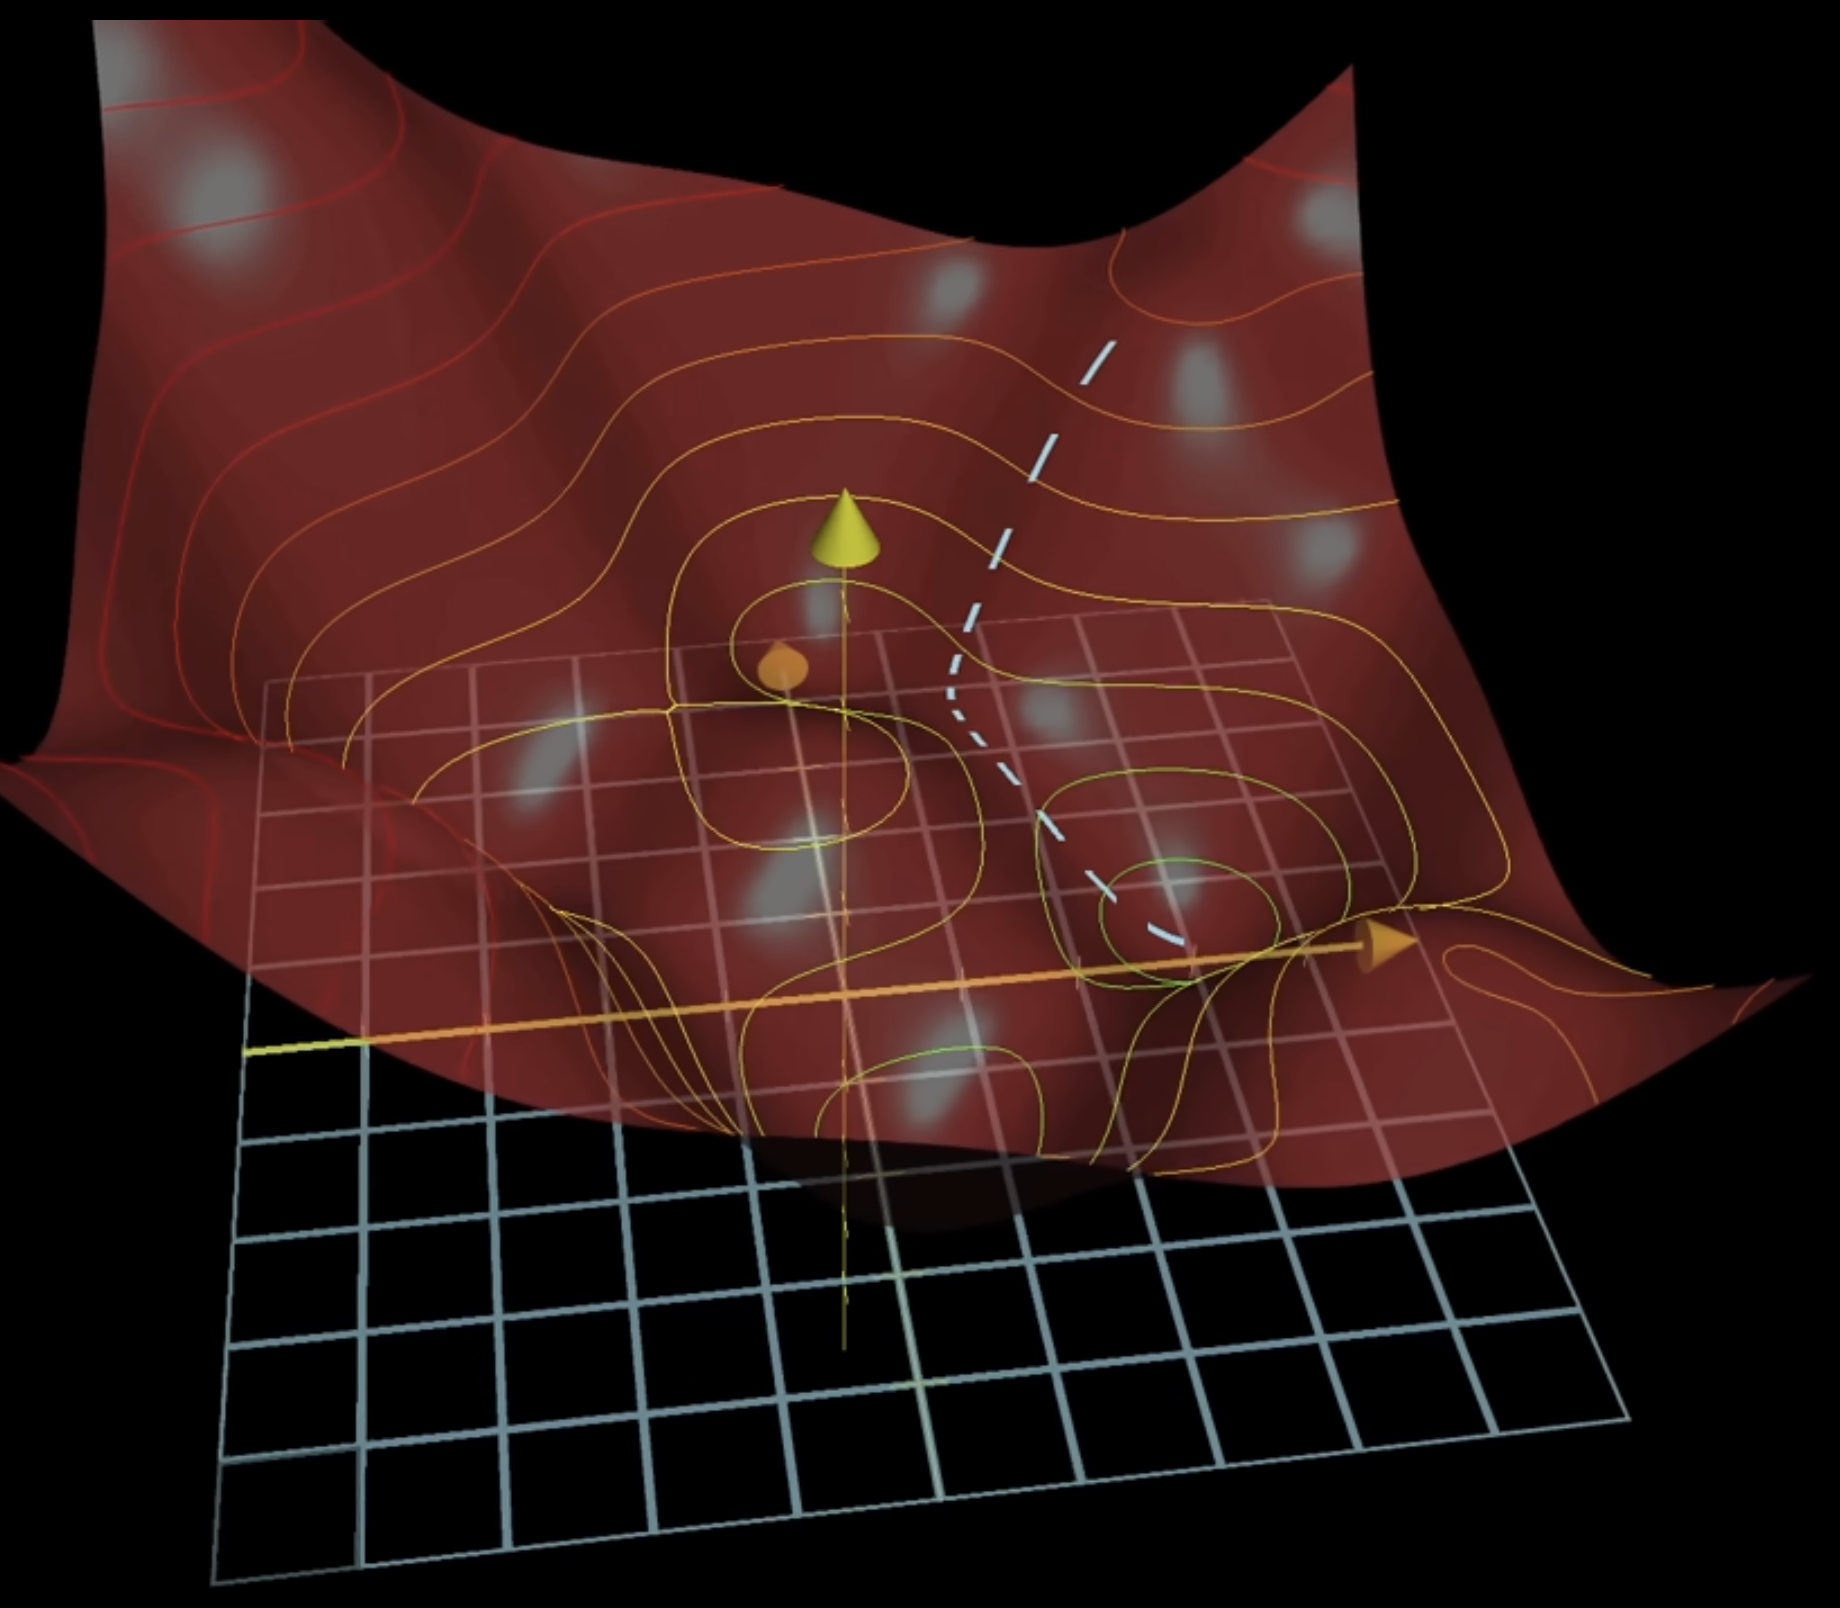

![Screenshot 2025-11-21 at 3.15.01 PM.png](<attachment:Screenshot 2025-11-21 at 3.15.01 PM.png>)

### I like how it shows the equation and which aspects can be shifted to change the weights between the neurons
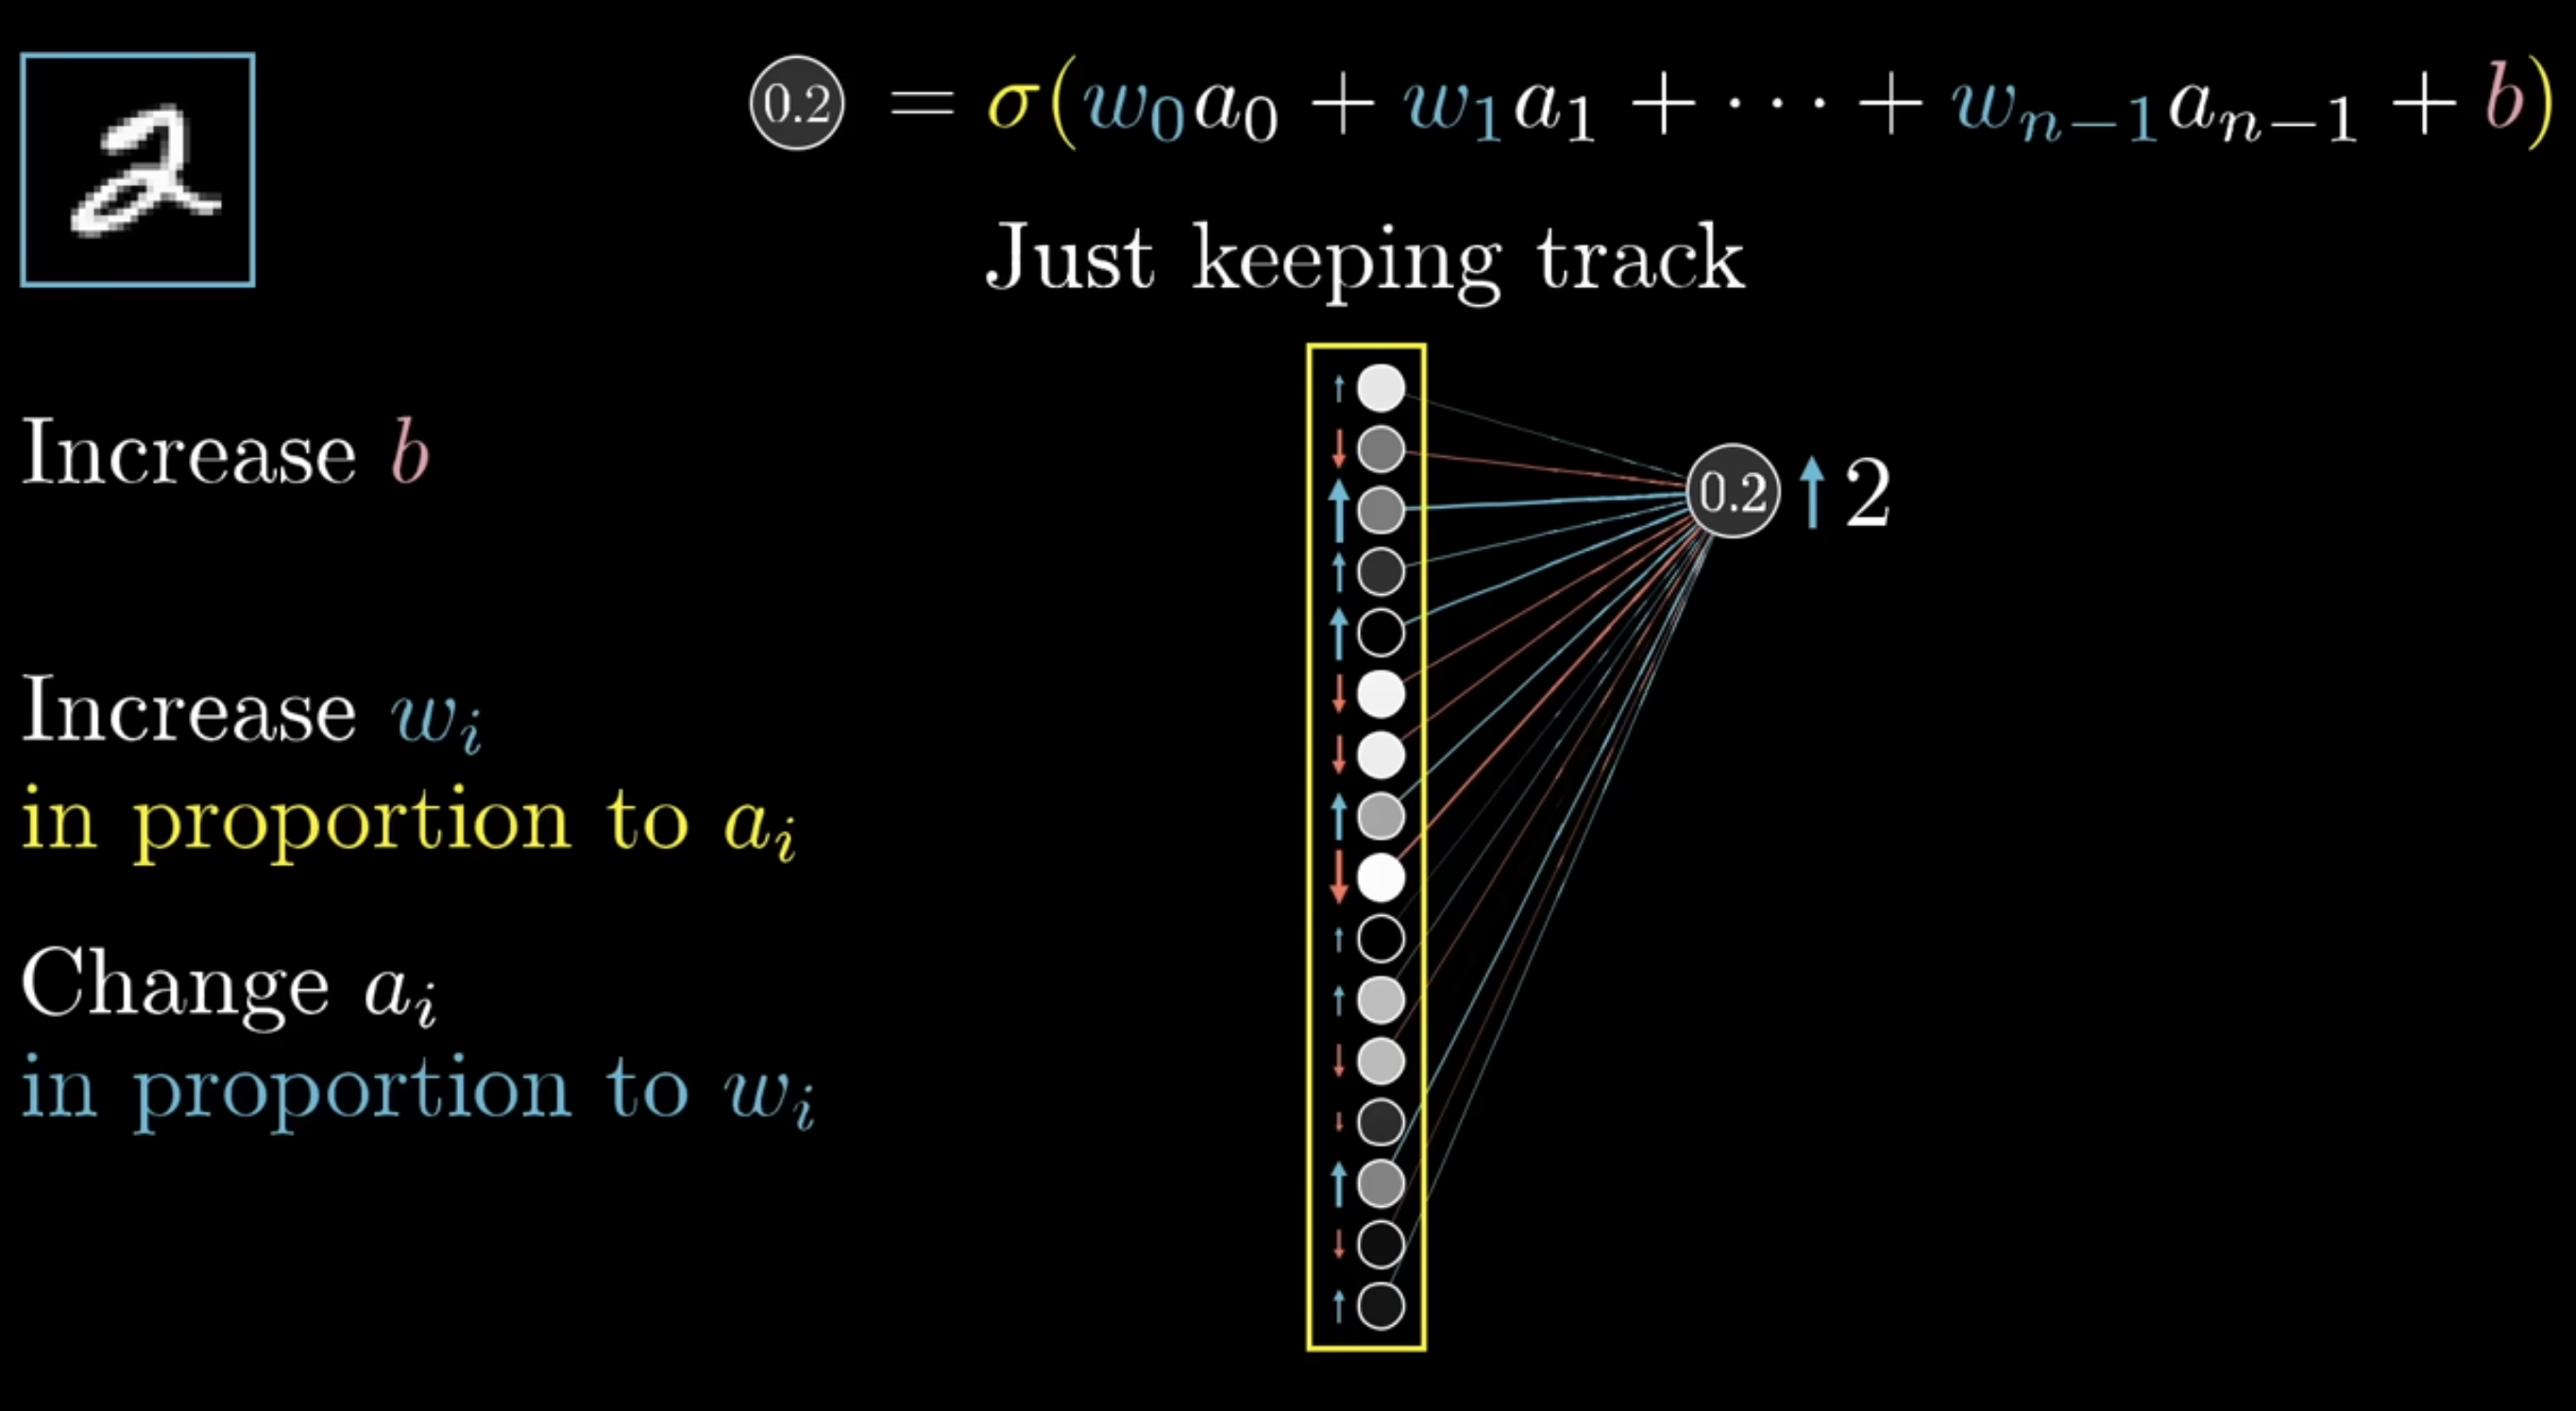

![Screenshot 2025-11-21 at 3.21.23 PM.png](<attachment:Screenshot 2025-11-21 at 3.21.23 PM.png>)

### Simplifying the network into 3 nodes with one neuron each and poviding the relavant equations to compute thc ost function. Very intuitive to think about, allows me to conceptualize it well
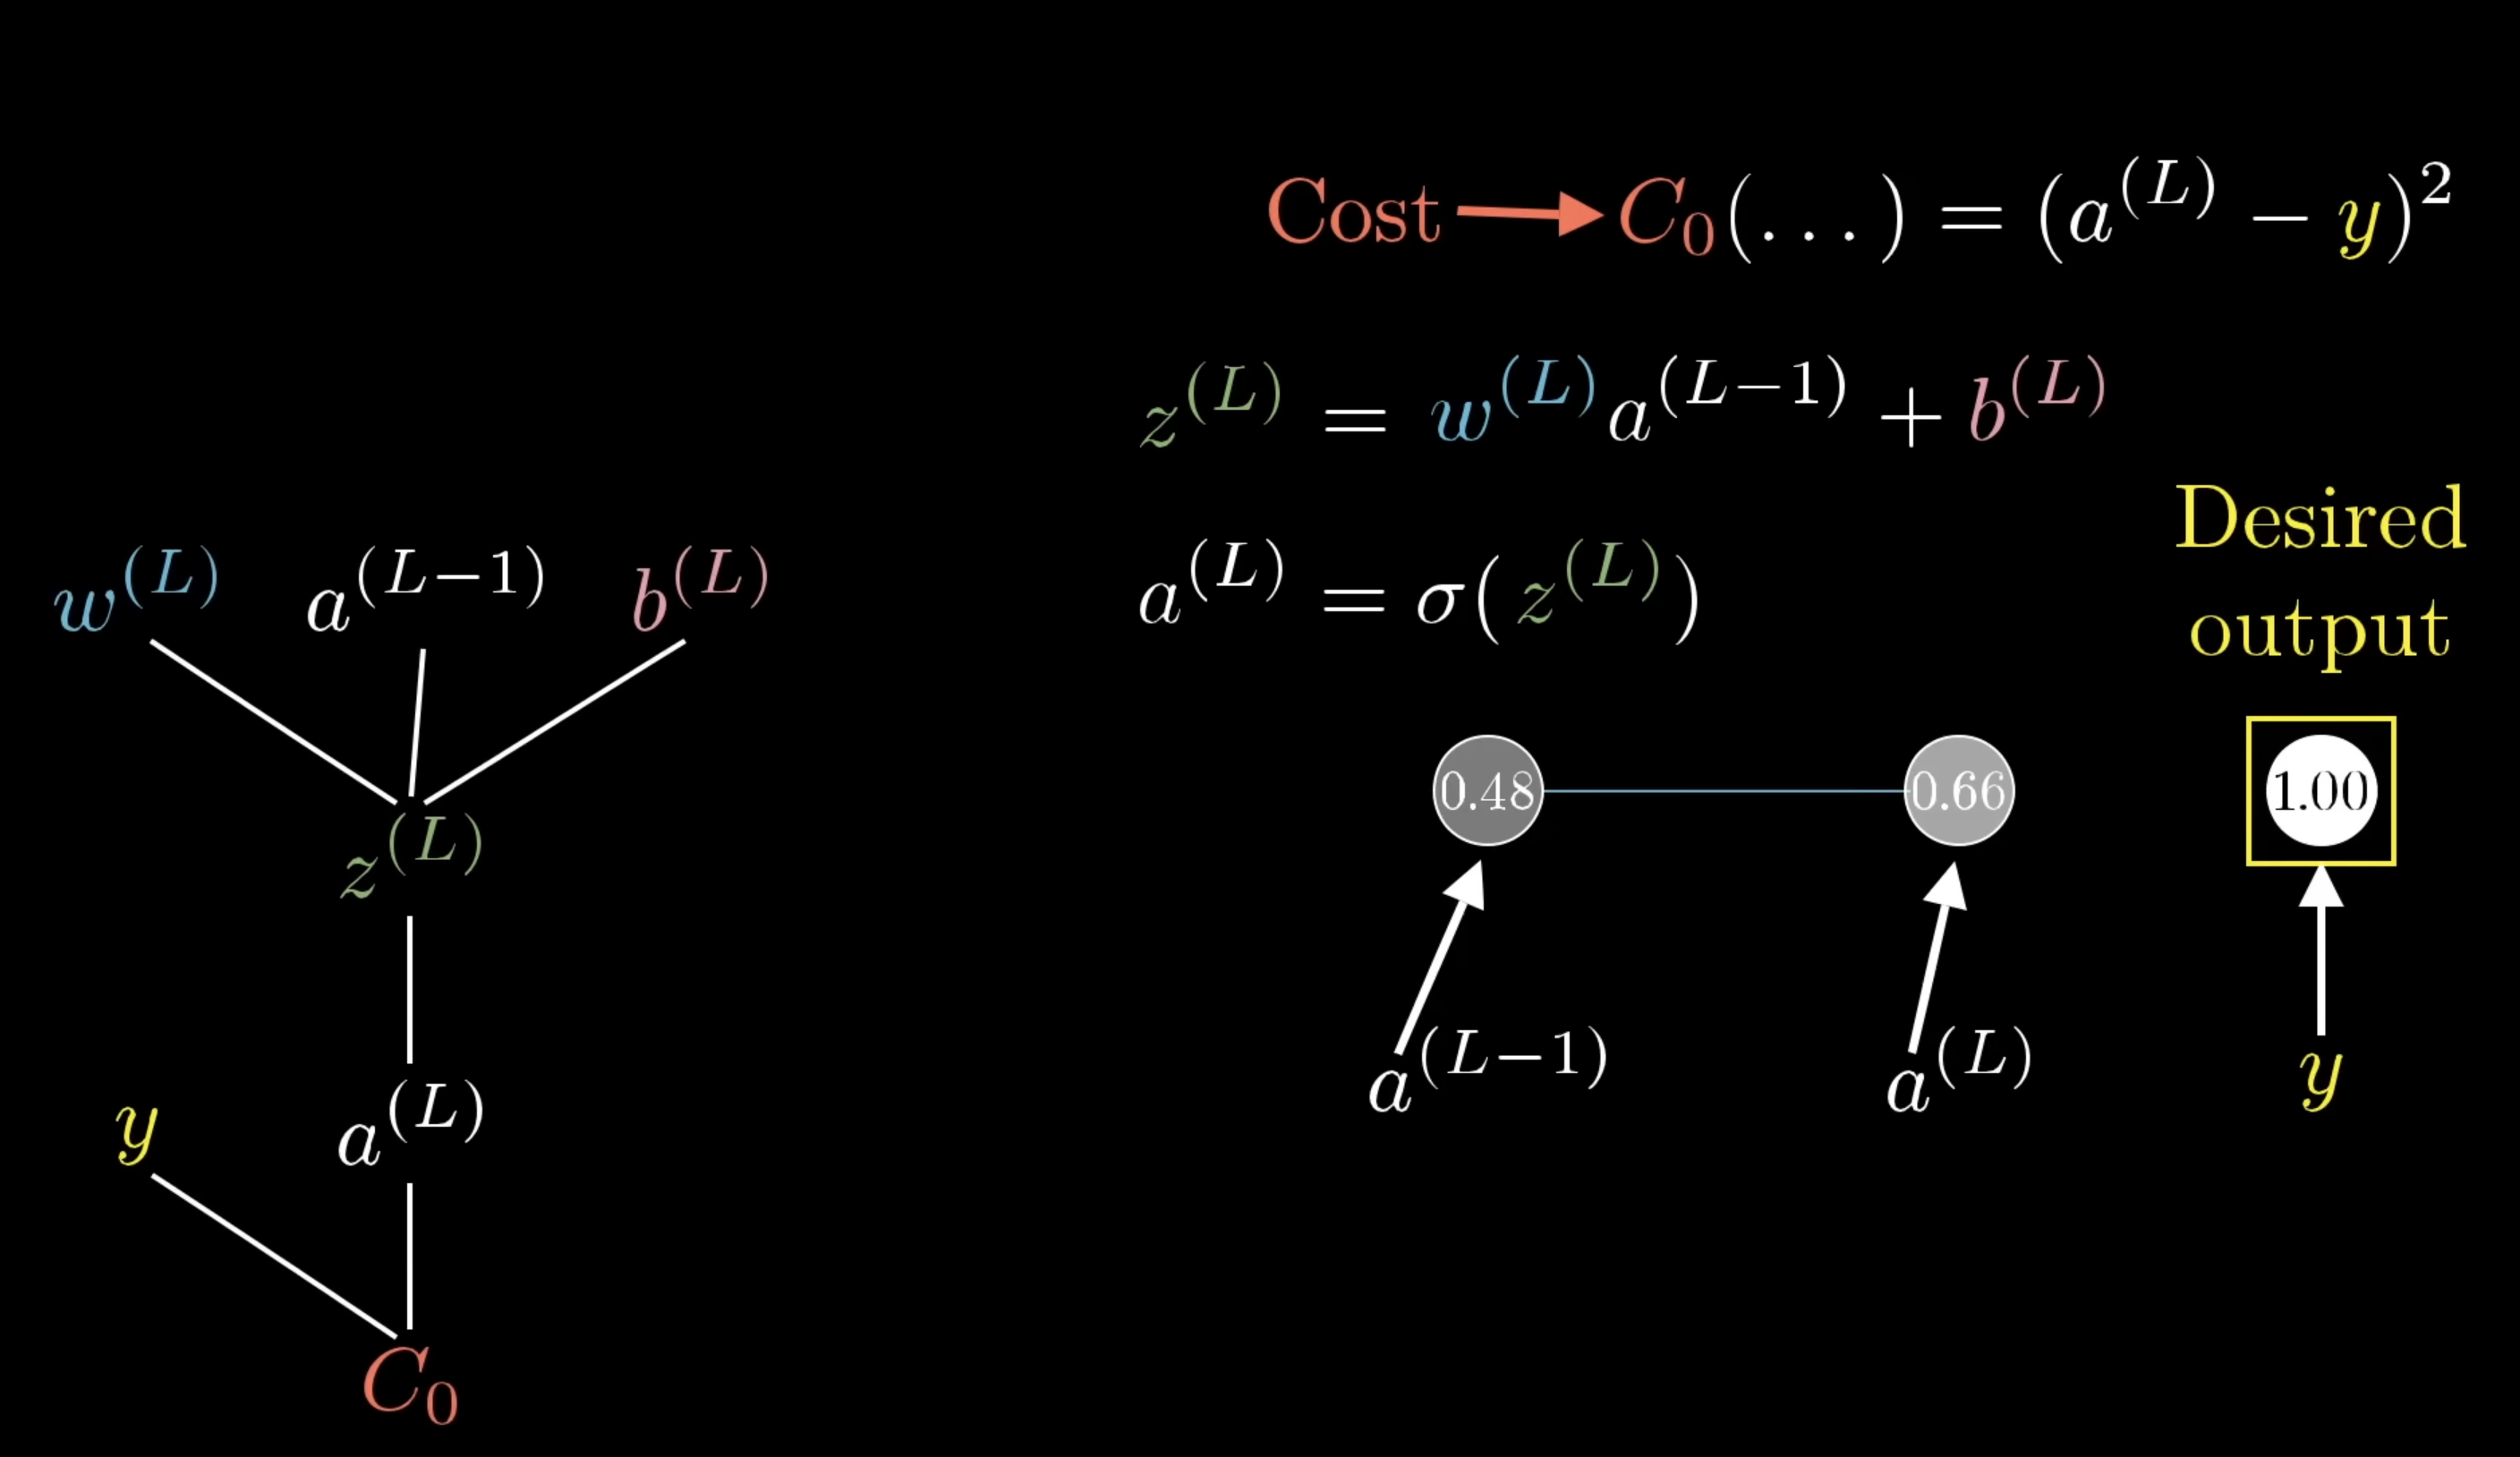

# Assignment 3

### Went through the colab notebook, don't know how I am supposed to provide proof of this. 

# Assignment 4

### I picked champters 19, 18, and 20 to go through. 

### **Ch 19**
### I picked chapter 19 because it goes though Markov chains and I really like Vertisaium's video on this subject. Ch 19 provides a  introduction to deep reinforcement learning (RL); it is a sequential decision-making framework where an agent learns to perform actions within an environment with the goal of maximizing received rewards. The chapter reviews foundational concepts such as Markov decision processes, and discusses core algorithmic approaches, including tabular methods, Deep Q-Learning, and Policy gradient methods that directly optimize the policy, which is particularly important in partially observable environments

### **Ch 18**
### Chapter 18 covers diffusion models (encoder/decoder, etc.). These are highly effective probabilistic generative models utilized in unsupervised learning. The model operates via a hierarchical latent variable framework that includes a prespecified encoder (forward process) to gradually transform input data into white noise. A deep learning model often a U-Net, learns the reverse process (decoder) to sequentially denoise the latent variables and generate samples. Diffusion models are easy to train and produce samples of very high quality, often exceeding the realism of GANs, and are used widely for image generation

### **Ch 20**
### Chapter 20 covers why deep learning is effective and the case for/against it. It discusses the challenges of optimizing high-dimensional loss functions and suggests that overparameterization and the choice of activation function are the two most important factors making training tractable in deep networks. Key concepts explored include the structure of the loss function, where the parameters move through a low-dimensional subspace to a family of connected minimums, and unexpected phenomena like double descent, grokking, and lottery tickets

# Assignment 5

### Completed assignment 5, my notebook is in my Homework 5 folder titled *17_MLIPs_HW5*